In [49]:
import numpy as np
import pandas as pd

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

from sklearn.model_selection import train_test_split
import tensorflow as tf


from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import keras.backend as K

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from keras.models import load_model

In [50]:
df = pd.read_csv("Twitter_Data.csv")

df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [51]:
df.isnull().sum()

,0
clean_text,4
category,7


In [52]:
df['category'].value_counts()

,count
category,
1.0,72250
0.0,55213
-1.0,35510


In [53]:
df.dropna(axis=0, inplace=True)

### Define categories

In [56]:
df['category'] = df['category'].map({-1.0: 'Negative', 0.0: 'Neutral', 1.0: 'Positive'})

In [83]:
df

,clean_text,category,vector_representation
0,when modi promised “minimum government maximum...,Negative,"[0.035855964, 0.0039416044, 0.10395716, 0.0907..."
1,talk all the nonsense and continue all the dra...,Neutral,"[0.03274205, -0.00013499767, 0.11190997, 0.095..."
2,what did just say vote for modi welcome bjp t...,Positive,"[0.028558217, 0.015365513, 0.12037839, 0.08367..."
3,asking his supporters prefix chowkidar their n...,Positive,"[0.032457568, 0.0048757866, 0.10212631, 0.0953..."
4,answer who among these the most powerful world...,Positive,"[0.033774763, 0.013620027, 0.10801445, 0.08959..."
...,...,...,...
162975,why these 456 crores paid neerav modi not reco...,Negative,"[0.04078171, 0.021051316, 0.09630021, 0.101968..."
162976,dear rss terrorist payal gawar what about modi...,Negative,"[0.031236717, 0.009665808, 0.103153124, 0.0968..."
162977,did you cover her interaction forum where she ...,Neutral,"[0.042834606, 0.0061998544, 0.10606003, 0.0949..."
162978,there big project came into india modi dream p...,Neutral,"[0.023645328, 0.022013327, 0.11030695, 0.08787..."


### Text-preprocessing

In [84]:
df['clean_text'] = df['clean_text'].str.lower()

### ENCODING

### Feature extraction

In [87]:
import gensim
from gensim.models import Word2Vec
word2vec_model = gensim.models.Word2Vec(sentences=df['clean_text'], vector_size=100, window=5, min_count=1, sg=1)

def sentence_to_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df['vector_representation'] = df['clean_text'].apply(lambda x: sentence_to_vector(x, word2vec_model))

In [91]:
df_1 = df[(df['category'] == 'Positive')]
df_2 = df[(df['category'] == 'Neutral')]
df_3 = df[(df['category'] == 'Negative')]

In [93]:
df_1 = df_1.sample(55000)

In [94]:
final_df = pd.concat([df_1,df_2,df_3])
final_df

,clean_text,category,vector_representation
101303,good modi asked ppl recognise those who trust ...,Positive,"[0.011720395, 0.013774082, 0.12062961, 0.00118..."
9495,why indians always used abusive language eithe...,Positive,"[0.015510939, 0.0062208227, 0.11720109, 0.0100..."
29689,\nthis shows the intensity fear frm which pak ...,Positive,"[0.021400575, 0.01387919, 0.11802393, 0.006637..."
155425,one more reason for namo once ’,Positive,"[0.011753249, 0.036681138, 0.089787126, -0.004..."
133886,employment india year high and modi asking how...,Positive,"[0.018045003, 0.018967632, 0.11750111, 0.00573..."
...,...,...,...
162956,when narender modi contested two seats was not...,Negative,"[0.014877524, 0.013365545, 0.11204513, 0.00555..."
162962,modi decimates congress front crores congress ...,Negative,"[0.007191059, 0.019330537, 0.094594344, 0.0115..."
162967,azamgarh please poor working requirement jogia...,Negative,"[0.0039166803, 0.021039195, 0.10774243, 0.0123..."
162975,why these 456 crores paid neerav modi not reco...,Negative,"[0.010448431, 0.015247794, 0.09208717, 0.01642..."


In [95]:
X_sm = df['vector_representation']
y_sm = df['category']

In [96]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy = 'minority')
X_sm , y_sm = smote.fit_resample(X,y)
X_sm, y_sm = smote.fit_resample(X_sm, y_sm)

In [98]:
X = np.vstack(df['vector_representation'].values)

y = pd.get_dummies(df['category']).values
print('Shape of label tensor:', y.shape)


X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)


Shape of label tensor: (162969, 3)


In [100]:

temp = pd.DataFrame(y_train)
temp.value_counts()

0  1  2
0  0  1    50720
   1  0    50662
1  0  0    50340
Name: count, dtype: int64

### Tokenizing and padding

### Saving tokenized data

In [17]:
len(X_train)

114078

In [18]:
def f1_score(precision, recall):
    ''' Function to calculate f1 score '''

    # Calculate F1 score
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

### RNN

In [107]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, SimpleRNN
import keras


model = Sequential([

    SimpleRNN(128,return_sequences=False,input_shape =(100,1)),


    Dense(1028, activation='relu'),
    Dense(712, activation='relu'),
    Dense(364, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),

    Dense(3, activation='softmax')

])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_7 (SimpleRNN)             │ (None, 128)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1028)                │         132,612 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 712)                 │         732,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 364)                 │         259,532 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 128)                 │          46,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,196,603 (4.56 MB)

 Trainable params: 1,196,603 (4.56 MB)

 Non-trainable params: 0 (0.00 B)

In [108]:
from tensorflow.keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping
print(model.summary())

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test,y_test),shuffle = True, callbacks=[early_stopping])


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_7 (SimpleRNN)             │ (None, 128)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1028)                │         132,612 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 712)                 │         732,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 364)                 │         259,532 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 128)                 │          46,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,196,603 (4.56 MB)

 Trainable params: 1,196,603 (4.56 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
4742/4742 ━━━━━━━━━━━━━━━━━━━━ 55s 11ms/step - accuracy: 0.3735 - loss: 1.0880 - val_accuracy: 0.4368 - val_loss: 1.0496
Epoch 2/20
4742/4742 ━━━━━━━━━━━━━━━━━━━━ 50s 10ms/step - accuracy: 0.4371 - loss: 1.0489 - val_accuracy: 0.4461 - val_loss: 1.0388
Epoch 3/20
4742/4742 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - accuracy: 0.4501 - loss: 1.0358 - val_accuracy: 0.4600 - val_loss: 1.0274
Epoch 4/20
4742/4742 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - accuracy: 0.4576 - loss: 1.0310 - val_accuracy: 0.4523 - val_loss: 1.0337
Epoch 5/20
4742/4742 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - accuracy: 0.4581 - loss: 1.0307 - val_accuracy: 0.4613 - val_loss: 1.0294
Epoch 6/20
4742/4742 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - accuracy: 0.4629 - loss: 1.0246 - val_accuracy: 0.4592 - val_loss: 1.0255
Epoch 7/20
4742/4742 ━━━━━━━━━━━━━━━━━━━━ 85s 11ms/step - accuracy: 0.4665 - loss: 1.0220 - val_accuracy: 0.4673 - val_loss: 1.0228
Epoch 8/20
4742/4742 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.4

In [112]:

loss,accuracy= model.evaluate(X_test, y_test, verbose=0)


# Print evaluation metrics
print(f"\nAccuracy  : {accuracy:.4f}")
print(f"\nloss  : {loss:.4f}")


Accuracy  : 0.4856

loss  : 1.0018


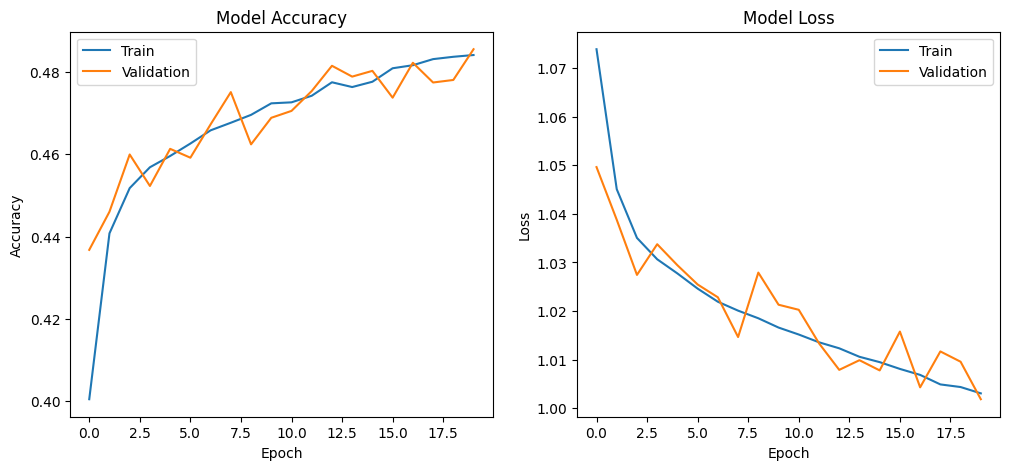

In [113]:
def plot_training_history(history):
    '''Plot accuracy and loss for training and validation'''

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy plot
    ax[0].plot(history.history['accuracy'], label='Train')
    ax[0].plot(history.history['val_accuracy'], label='Validation')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Loss plot
    ax[1].plot(history.history['loss'], label='Train')
    ax[1].plot(history.history['val_loss'], label='Validation')
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.show()

# Call the function
plot_training_history(history)


2033/2033 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


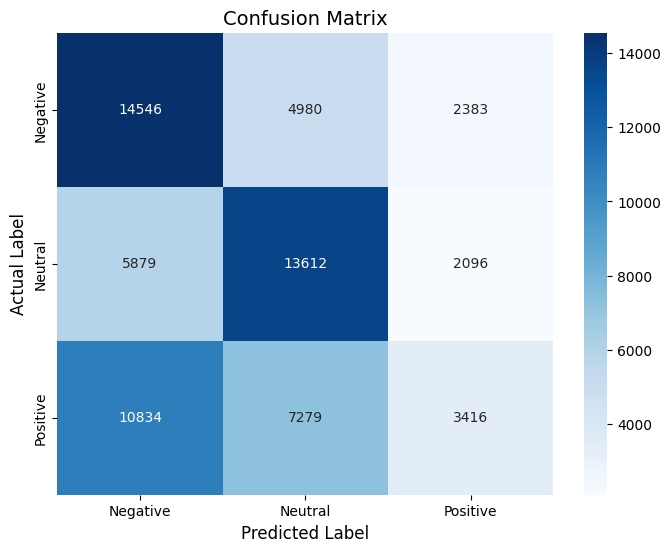

In [114]:
def plot_confusion_matrix(model, X_test, y_test):
    '''Plots the confusion matrix for the model predictions'''

    # Define sentiment labels
    labels = ['Negative', 'Neutral', 'Positive']

    # Predict the classes
    y_pred = model.predict(X_test)

    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt='d', xticklabels=labels, yticklabels=labels)

    plt.title('Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('Actual Label', fontsize=12)
    plt.show()

# Call the function
plot_confusion_matrix(model, X_test, y_test)

In [115]:
# Save the trained model
model.save('best_model.h5')
print("Best model saved successfully!")

Best model saved successfully!


In [120]:
model = load_model('best_model.h5')

def predict_class(text):
    """Predict the sentiment class of the given text."""

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len = 50


    xt = sentence_to_vector(text,word2vec_model)

    xt = xt.reshape(1,100,1)
    yt = model.predict(xt).argmax(axis=1)

    # Output the predicted sentiment
    print(f'The predicted sentiment is: {sentiment_classes[yt[0]]}')

In [121]:
predict_class(["not happy sad negative naive"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
The predicted sentiment is: Neutral
